### Semester Project              -              Master in Robotics              -              Yanis Bouadi (283606)



## Importing Libraries

In [1]:
# Packages
import os
import cv2
import skimage.io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import ndimage, misc
import scipy.interpolate
from math import cos, sin, degrees, radians, hypot
from skimage import measure, morphology, filters, data
import skimage.segmentation
from skimage.morphology import opening, erosion, square, closing, disk, dilation
from skimage.transform import rotate, rescale, SimilarityTransform
from MTM import matchTemplates, drawBoxesOnRGB


## Functions

In [25]:
def CREATE_Lab(image,mode,number_of_seeds,stage):
    
    # Parameters 
    nb_roots=number_of_seeds
    threshold_contour=0.6
    threshold_pixel=100
    if stage=='early':
        threshold_depth=20 #20# minimum depth of a root (less than this threshold, it's not detected as a root)
    if stage=='late':
        threshold_depth=100
    im=image[:,:,0].copy()

    mean_im = int(image[:,:,0].mean())
    max_im  = int(image[:,:,0].max())
    min_im  = int(image[:,:,0].min())
    thre_im = (max_im + min_im)/2

    im[im>thre_im]=255
    im[im<=thre_im]=0
    K_min=nb_roots-5
    K_max=nb_roots+5
    thresh_v_min=30


    # -------------------------------------------------------------------------------------------------#



    contours0 = measure.find_contours(im,threshold_contour, fully_connected='low',positive_orientation='low')   
    nb_dilation,contours,nb_root_detected=0,[],[]
    Mode=0

    if mode=='Fast':
        Mode=1
    if mode=='Recommended':
        Mode=3
    if mode=='Accurate':
        Mode=5
    if mode=='Very Accurate':
        Mode=8
    #print('Initial number of contour detected is: ',len(contours0))

    # In this while loop, we remove noisy contours: 
    # Narrow down the number of contour detected from thousands 
    # to a number around the number of seeds planted by binary thresholding AND dilation
    while(len(contours0) != nb_roots and nb_dilation<Mode):
        nb_dilation+=1
        ind=0  
        contours0 = measure.find_contours(im,threshold_contour, fully_connected='low',positive_orientation='low')
        contours.append(contours0)

        # Binary adaptative thresholding
        while ( len(contours0) < K_min or len(contours0) > K_max ):
            ind+=1

            if len(contours0)>nb_roots and threshold_pixel > 300:
                threshold_pixel = threshold_pixel + 10

            if len(contours0)<nb_roots and threshold_pixel > 300:
                im=skimage.color.rgb2gray(binary)
                contours0 = measure.find_contours(im,threshold_contour)
                threshold_pixel = threshold_pixel - 10

            for i in range(len(contours0)-1,-1,-1):
                v_min , v_max = min(contours0[i][:,0]) , max(contours0[i][:,0])

                if ( (len(contours0[i])<=threshold_pixel) or (v_max-v_min < threshold_depth) or (v_min)>thresh_v_min):
                    contours0[i]=[]        
                    contours0.remove([])

            if (ind > 130):  # To avoid infinite loop           
                break
        nb_root_detected.append(len(contours0))
        
        # Dilation fine tuning
        im=dilation(im)
        print(" Fine tuning in progress, please wait ...")
        print("")
        if nb_dilation>=Mode:
            break

    nb_root_detected= abs(nb_root_detected - nb_roots*np.ones(len(nb_root_detected)))
    ind_nb_rd=np.argmin(nb_root_detected)
    contours0=contours[ind_nb_rd]
    for e in range(Mode-ind_nb_rd):
        im=erosion(im)

    # ----------------------------------------------#
    print(" Computing Lengths/Depths of main roots, please wait ...")
    print("")
    fig, ax = plt.subplots(figsize=(9, 9))


    depth_roots,means,idx=[],[],[]

    for contour in contours0:


        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        v_min , v_max = min(contour[:,0]) , max(contour[:,0])
        depth_root=round((v_max-v_min)*scale,1)

        m=np.mean(contour,axis=0)
        means.append(m[1])
        idx=np.argsort(means)

        if contour[len(contour)-1][1]<contour[0][1]:
                contour=contour[::-1]

        depth_roots.append(depth_root)

    contours0=[contours0[i] for i in idx] # sort all the root regarding the horizontal axis
    depth_roots=[depth_roots[i] for i in idx]
    ax.imshow(im,cmap='gray')




    # -------------------------------------------------------------------------------------------------#



    nb_segment,nb_lateral_root=[],[]
    main_roots,main_roots_depths,main_roots_lengths=[],[],[]
    lateral_roots,laterals_roots_depths=[],[]
    contours2=[]
    cnt_remove=0
    print(" Segmentation of lateral roots in progress, please wait ...")
    print("")
    for N in range(0,len(contours0)):

        contours1,black=[],[]
        black=image.copy()
        black[:,:,:]=0
        max_pos=0
        for s in range(2,len(contours0[N])):
            if (contours0[N][s-5][0]<contours0[N][s][0] and contours0[N][s][0]>max_pos ):
                max_pos=max(max_pos,contours0[N][s][0])
                black[int(contours0[N][s][0]),int(contours0[N][s][1]),: ] = 255
        
        black=dilation(black) ; black=dilation(black) ; black=dilation(black)
        im=black[:,:,0].copy()

        contours1 = measure.find_contours(im,threshold_contour, fully_connected='low',positive_orientation='low')   
        contours2.append(contours1)
        
        black=erosion(black) ; black=erosion(black) ; black=erosion(black)
        nb_segment.append(len(contours1))
    black=dilation(black) ; black=dilation(black) ; black=dilation(black)

    for j in range(len(nb_segment)):
        cnt=0
        lateral_roots_depth=[]
        if ( nb_segment[j]==0 ):
            main_roots_depth=0
            lateral_roots_depth=[]
            lateral_roots.append([])
            nb_lateral_root.append(0)
            main_roots.append([0])
            
        if ( nb_segment[j]==1 ):
            v_min , v_max = min(contours2[j][0][:,0]) , max(contours2[j][0][:,0])
            nb_lateral_root.append(0)
            main_roots.append(contours2[j][0]) #Store the main root contour
            lateral_roots.append([])
            main_roots_depth=round((v_max-v_min)*scale,2)
            lateral_roots_depth=[]
            L=0
            #print(len(main_roots[j]))
            for i in range(1,len(main_roots[j])-1):
                L+=np.sqrt( np.square(main_roots[j][i][0]-main_roots[j][i-1][0]) + np.square(main_roots[j][i][1]-main_roots[j][i-1][1]) )
            L=round(L*0.5*scale,2) 
            
        if ( nb_segment[j]>1 ): 
            contours2[j]=sorted(contours2[j], key=len)
            v_min , v_max = min(contours2[j][-1][:,0]) , max(contours2[j][-1][:,0])
            main_roots.append(sorted(contours2[j], key=len)[-1]) #Store the main root contour (largest contour)
            main_roots_depth=round((v_max-v_min)*scale,2)
            ind_nb_lr=0
            L,L1=0,0
            
            for n in range(nb_segment[j]-1):
                v_min , v_max = min(contours2[j][n][:,0]) , max(contours2[j][n][:,0])
                h_min , h_max = min(contours2[j][n][:,1]) , max(contours2[j][n][:,1])
                if ( round((v_max-v_min)*scale,2)>0.15 and round((h_max-h_min)*scale,2)>0.15 ):
                    lateral_roots_depth.append(round((v_max-v_min)*scale,2))
                    #L1+=round((v_max-v_min)*scale,2)
                    L+=round((v_max-v_min)*scale,2)
                    lateral_roots.append(sorted(contours2[j], key=len)[n])
                    ind_nb_lr+=1

            for i in range(1,len(main_roots[j])-1):
                L+=np.sqrt( np.square(main_roots[j][i][0]-main_roots[j][i-1][0]) + np.square(main_roots[j][i][1]-main_roots[j][i-1][1]) )
            L=round(L*0.5*scale,2)        
                    
            nb_lateral_root.append(ind_nb_lr) 

        main_roots_depths.append(main_roots_depth)
        laterals_roots_depths.append(lateral_roots_depth)
        main_roots_lengths.append(L)


    # Final adjustements: size adaptative threshold    
    thresh_roots_minimum=0.1

    while ( len(main_roots_depths)>nb_roots ):
        thresh_roots_minimum+=0.05
        les_indices = [elem for elem in range(len(main_roots_depths)) if main_roots_depths[elem]>thresh_roots_minimum]

        main_roots_depths = [i for j, i in enumerate(main_roots_depths ) if j in les_indices]
        main_roots = [i for j, i in enumerate(main_roots ) if j in les_indices]
        main_roots_lengths = [i for j, i in enumerate(main_roots_lengths ) if j in les_indices]

        laterals_roots_depths = [i for j, i in enumerate(laterals_roots_depths ) if j in les_indices]
        lateral_roots = [i for j, i in enumerate(lateral_roots ) if j in les_indices]
        nb_lateral_root = [i for j, i in enumerate(nb_lateral_root ) if j in les_indices]  

    print(" All Good! Results are ready :p ")
    print("")
    print(len(main_roots),'main roots are detected:')


    # -------------------------------------------------------------------------------------------------#
    # Display the image and plot all the contours

    black[:,:,:] = 255
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(black)
    for contour in main_roots:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='red')
    for contour in lateral_roots: 
        if len(contour)>=1:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    print(" Green lines are associated to the main root / Colored lines (if any) are associated to lateral roots ")
    plt.show()

    # Summary of all the results

    df = pd.DataFrame(list(zip(main_roots_depths, main_roots_lengths,nb_lateral_root,laterals_roots_depths))) 
    df.columns = ["Main Root Depth [cm]" , "Main Root Length [cm]" , "Number of lateral roots" , " Lateral root depths [cm]"]
    df.index = ["Root "+ str(i) for i in range(1,len(main_roots_depths)+1) ]
    df.loc[len(df.index)] = [np.mean(main_roots_depths), np.mean(main_roots_lengths), round(np.mean(nb_lateral_root),1),["-"]]
    df.loc[len(df.index)] = [depth_gt, length_gt, ["-"],["-"]]
    df.loc[len(df.index)] = [abs(depth_gt-np.mean(main_roots_depths))*100/depth_gt, abs(length_gt-np.mean(main_roots_lengths))*100/length_gt, ["-"],["-"]]

    #df.loc[len(df.index)] = [f_depth,f_length,["-"]]
    df = df.rename(index={len(main_roots_depths): 'Mean values'})
    df = df.rename(index={len(main_roots_depths)+1: 'GT Mean values'})
    df = df.rename(index={len(main_roots_depths)+2: 'Error [%]'})
    df=df.round(2)
    return [main_roots_depths, main_roots_lengths,nb_lateral_root,laterals_roots_depths],df

In [18]:
def error_d(x):
    a = round(abs(depth_gt-np.mean(x))*100/depth_gt,1)
    return a

def error_l(x):
    a = round(abs(length_gt-np.mean(x))*100/length_gt,1)
    return a

def Accuracy(mode,metrics,depth_gt , length_gt):

    df = pd.DataFrame(np.array([[error_d(metrics[0])], 
                                 [error_l(metrics[1])]]),
                       columns=['Mode '+str(mode) ])
    df.index = ['Error Depth [%]','Error Length [%]']
    df=df.round(2)
    return df

## Influence of dilation - Early stage roots

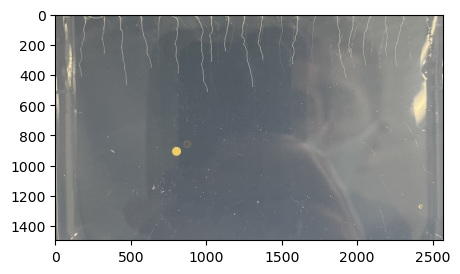

In [19]:
image_initiale= []
image_initiale=skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/1:1cbis.jpg'))

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initiale)

In [20]:
nb_roots=21
depth_gt , length_gt = 1.50, 1.53  
scale= 7.5/image_initiale.shape[0] 

## Mode 'Fast'
metrics_F , df_F = CREATE_Lab(image_initiale,'Fast',nb_roots,'early')
df_F
Accuracy('Fast',metrics_F,depth_gt , length_gt)


## Mode 'Recommended'
metrics_R , df_R = CREATE_Lab(image_initiale,'Recommended',nb_roots,'early')
df_R
Accuracy('Recommended',metrics_R,depth_gt , length_gt)


## Mode 'Accurate'
metrics_A , df_A = CREATE_Lab(image_initiale,'Accurate',nb_roots,'early')
df_A
Accuracy('Accurate',metrics_A,depth_gt , length_gt)

In [21]:
# Compare the error between the 3 modes

df2 = pd.DataFrame(np.array([[error_d(metrics_F[0]),error_d(metrics_R[0]),error_d(metrics_A[0])], 
                            [error_l(metrics_F[1]),error_l(metrics_R[1]), error_l(metrics_A[1])]]),
                   columns=[' Mode "Fast" ',' Mode "Recommended" ',' Mode "Accurate" ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
df2 

## Influence of dilation - Late stage roots

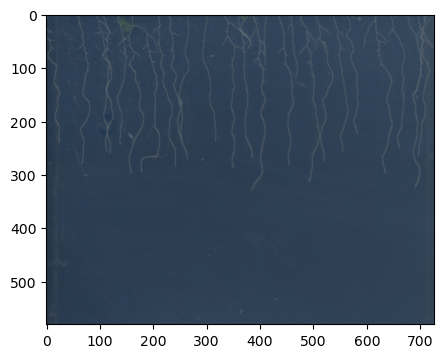

In [22]:
image_initiale= []
image_initiale=skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/IMAGE2.png'))


image_initiale= image_initiale[120:700,40:-50,:] # IMAGE2  Crop the image [vetical axis,horizontal axis,:]

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initiale)

<ipython-input-17-79ae04961d17>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Computing Lengths/Depths of main roots, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

15 main roots are detected:
 Green lines are associated to the main root / Colored lines (if any) are associated to lateral roots 


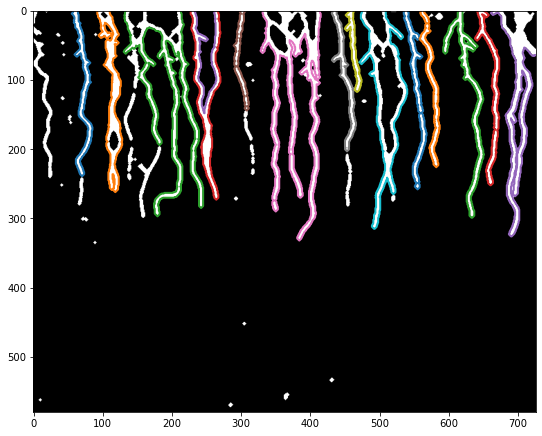

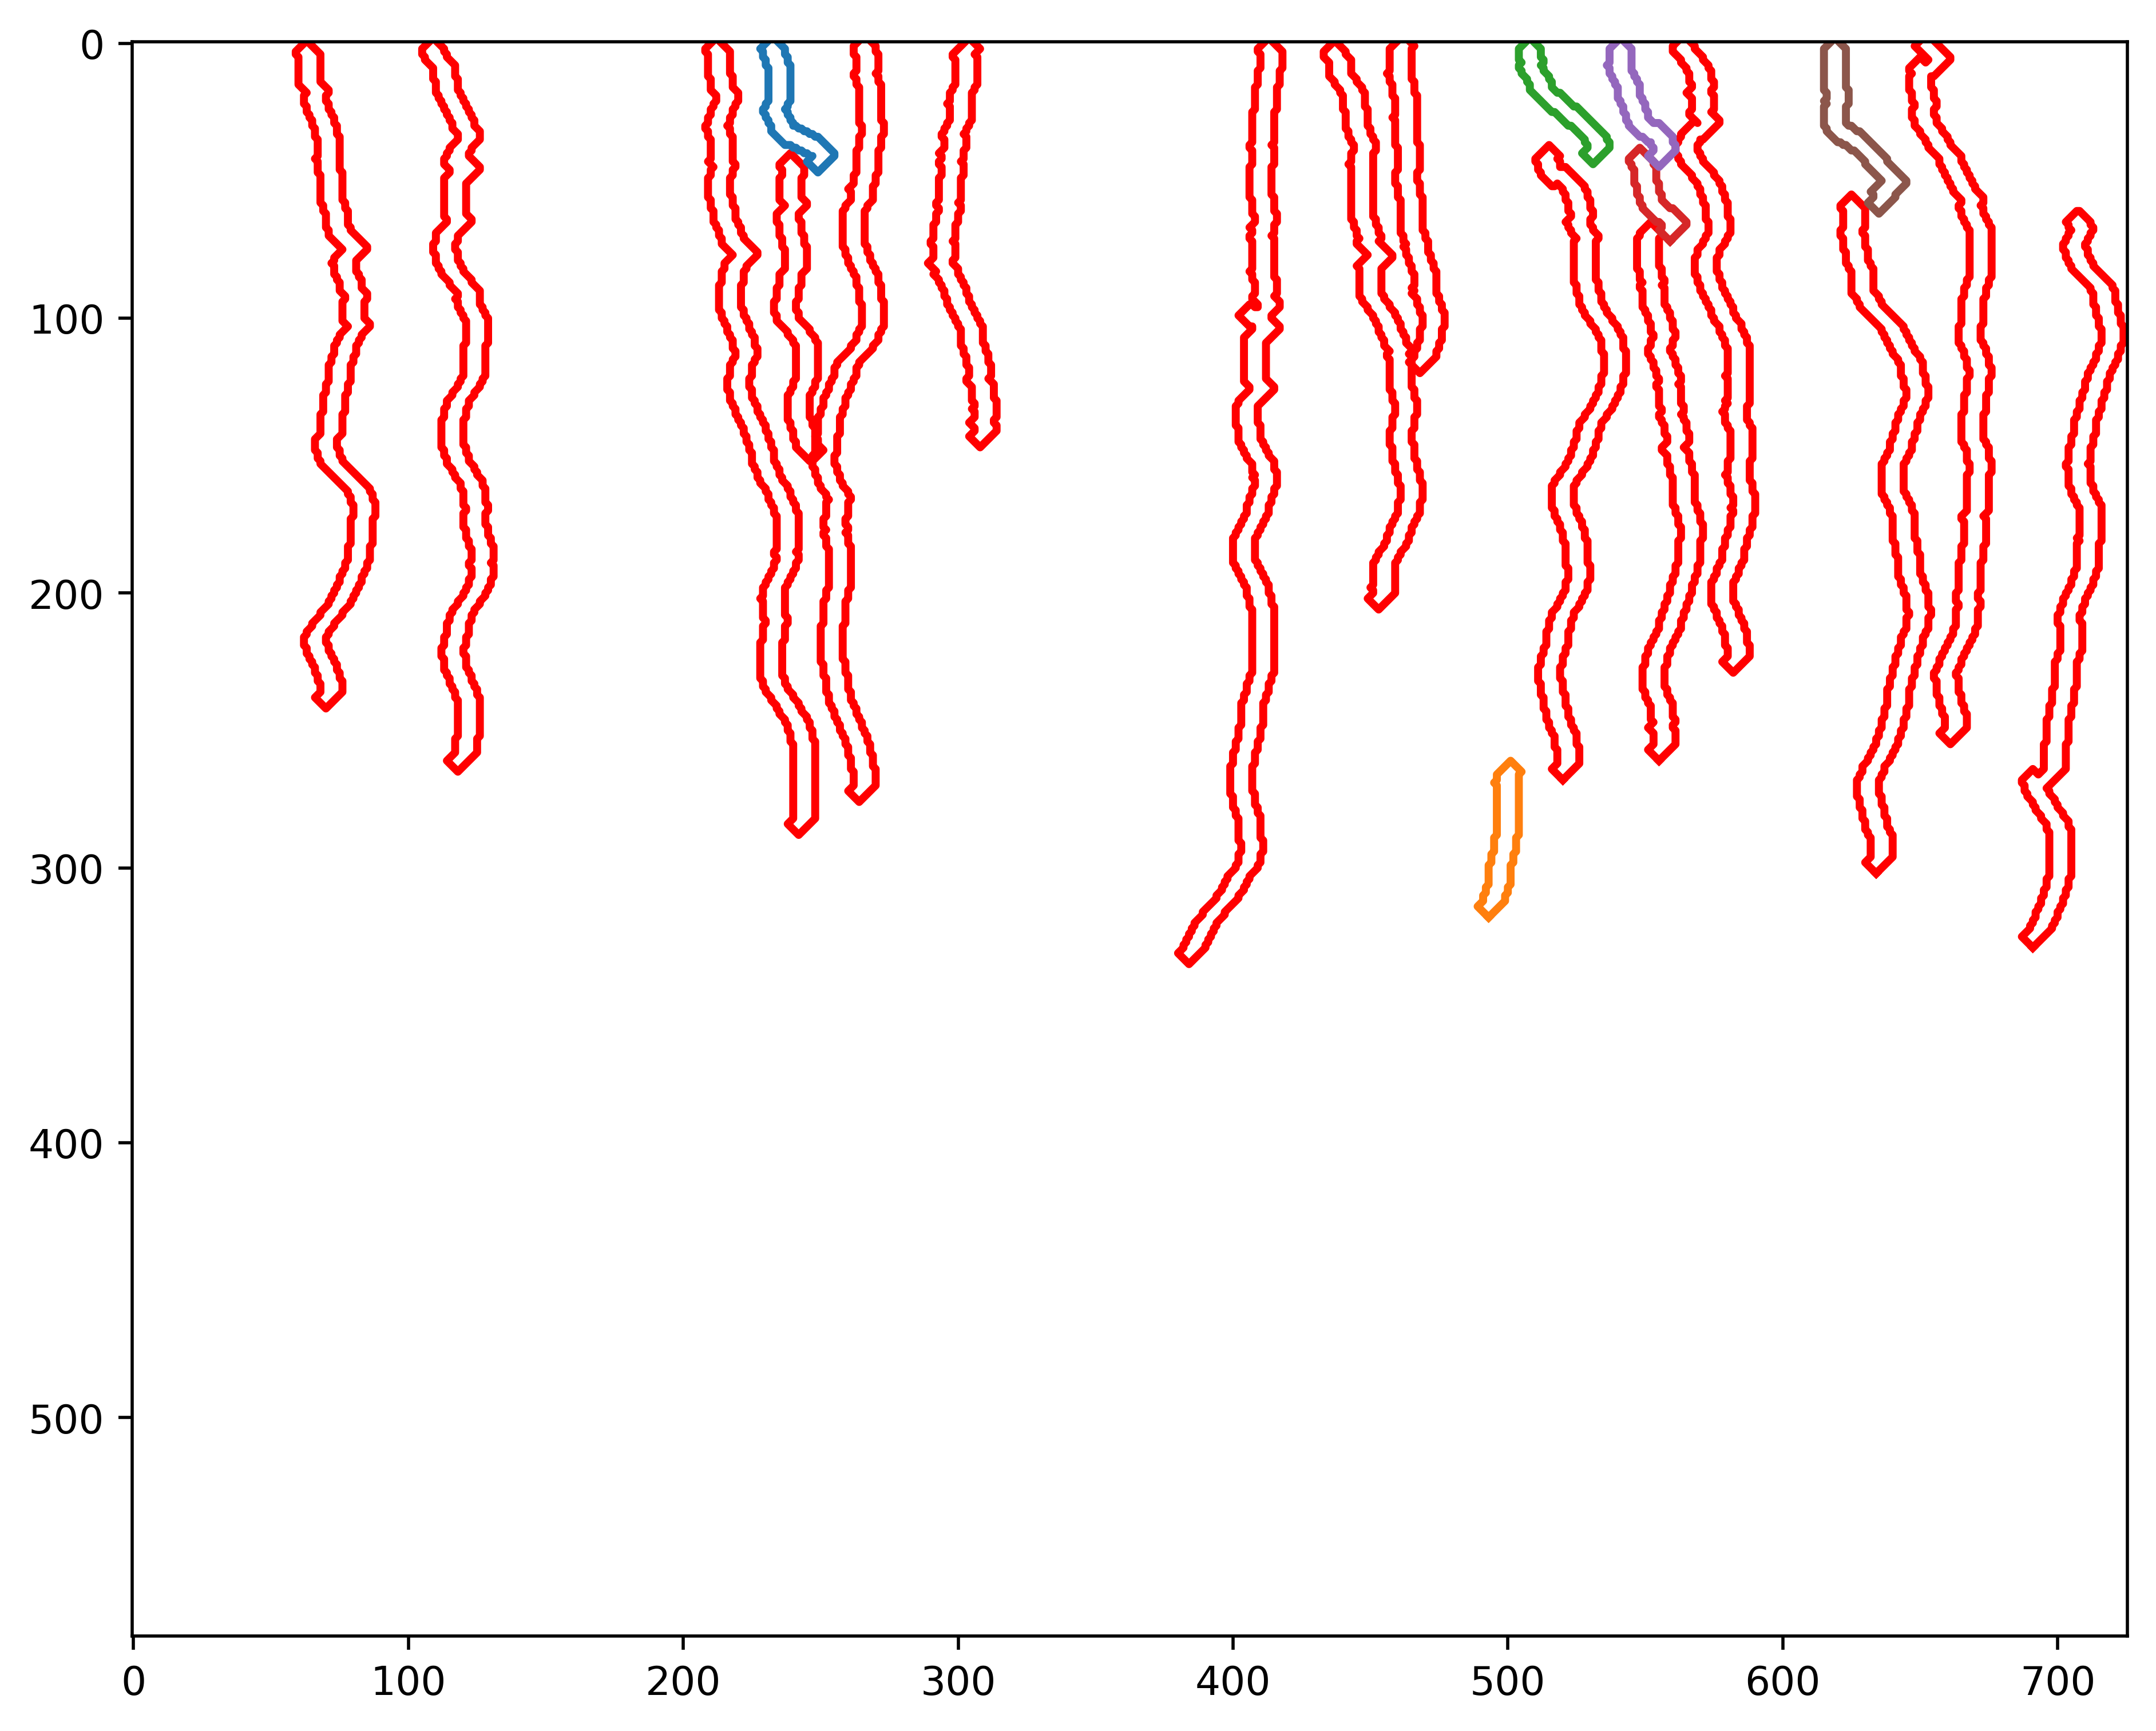

In [23]:
nb_roots=25
depth_gt , length_gt = 3.75, 3.93 
scale= 8.5/image_initiale.shape[0] 


## Mode 'Fast'
metrics_F , df_F = CREATE_Lab(image_initiale,'Fast',nb_roots,'late')
df_F
Accuracy('Fast',metrics_F,depth_gt , length_gt)


## Mode 'Recommended'
metrics_R , df_R = CREATE_Lab(image_initiale,'Recommended',nb_roots,'late')
df_R
Accuracy('Recommended',metrics_R,depth_gt , length_gt)


## Mode 'Accurate'
metrics_A , df_A = CREATE_Lab(image_initiale,'Accurate',nb_roots,'late')
df_A
Accuracy('Accurate',metrics_A,depth_gt , length_gt)

In [24]:
# Compare the error between the 3 modes

df2 = pd.DataFrame(np.array([[error_d(metrics_F[0]),error_d(metrics_R[0]),error_d(metrics_A[0])], 
                             [error_l(metrics_F[1]),error_l(metrics_R[1]), error_l(metrics_A[1])]]),
                   columns=[' Mode "Fast" ',' Mode "Recommended" ',' Mode "Accurate" ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
df2 

NameError: name 'metrics_F' is not defined

## Influence of Contrast - Early stage roots

In [ ]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/L80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/L50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/L20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/1:1cbis.jpg'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/H80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/H50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/H20.png'))

image_initialeL80= image_initialeL80[240:600,90:-100,:] 
image_initialeL50= image_initialeL50[240:600,90:-100,:] 
image_initialeL20= image_initialeL20[240:600,90:-100,:] 

#image_initialeI= image_initialeI[240:600,90:-90,:] 

image_initialeH80= image_initialeH80[240:600,90:-100,:] 
image_initialeH50= image_initialeH50[240:600,90:-100,:] 
image_initialeH20= image_initialeH20[240:600,90:-100,:] 


plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeH80)

In [ ]:
nb_roots=21
depth_gt , length_gt = 1.50, 1.53  

# Contrast: - 80%
scale= 7.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'early')

# Contrast: - 50%
scale= 7.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'early')

# Contrast: - 20%
scale= 7.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'early')

# Contrast: 0%
scale= 7.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'early')

# Contrast: + 20%
scale= 7.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'early')

# Contrast: +50%
scale= 7.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'early')

# Contrast: +80%
scale= 7.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'early')


In [ ]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)

df2

## Influence of Brightness - Early stage roots

In [ ]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BL80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BL50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BL20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/1:1cbis.jpg'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BH80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BH50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BH20.png'))

image_initialeL80= image_initialeL80[240:600,90:-100,:] 
image_initialeL50= image_initialeL50[240:600,90:-100,:] 
image_initialeL20= image_initialeL20[240:600,90:-100,:] 

#image_initialeI= image_initialeI[240:600,90:-90,:] 

image_initialeH80= image_initialeH80[240:600,90:-100,:] 
image_initialeH50= image_initialeH50[240:600,90:-100,:] 
image_initialeH20= image_initialeH20[240:600,90:-100,:] 

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeH80)

In [ ]:
nb_roots=21
depth_gt , length_gt = 1.50, 1.53  

# Brightness: - 80%
scale= 7.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'early')

# Brightness: - 50%
scale= 7.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'early')

# Brightness: - 20%
scale= 7.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'early')

# Brightness: 0%
scale= 7.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'early')

# Brightness: + 20%
scale= 7.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'early')

# Brightness: +50%
scale= 7.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'early')

# Brightness: +80%
scale= 7.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'early')



In [ ]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)

df2

## Influence of Contrast - Late stage roots

In [ ]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CHM80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CHM50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CHM20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/IMAGE2.png'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CH80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CH50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CH20.png'))

image_initialeI= image_initialeI[120:700,40:-50,:] # IMAGE2  Crop the image [vetical axis,horizontal axis,:]

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeI)

In [ ]:
nb_roots=25
depth_gt , length_gt = 3.75, 3.93 

# Contrast: - 80%
scale= 8.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'late')

# Contrast: - 50%
scale= 8.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'late')

# Contrast: - 20%
scale= 8.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'late')

# Contrast: 0%
scale= 8.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'late')

# Contrast: + 20%
scale= 8.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'late')

# Contrast: +50%
scale= 8.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'late')

# Contrast: +80%
scale= 8.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'late')


In [ ]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
df2

## Influence of Brightness - Late stage roots

In [ ]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBL80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBL50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBL20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/IMAGE2.png'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBH80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBH50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBH20.png'))

image_initialeI= image_initialeI[120:700,40:-50,:] # IMAGE2  Crop the image [vetical axis,horizontal axis,:]

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeI)

In [ ]:
nb_roots=25
depth_gt , length_gt = 3.75, 3.93 

# Brightness: - 80%
scale= 8.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'late')

# Brightness: - 50%
scale= 8.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'late')

# Brightness: - 20%
scale= 8.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'late')

# Brightness: 0%
scale= 8.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'late')

# Brightness: + 20%
scale= 8.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'late')

# Brightness: +50%
scale= 8.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'late')

# Brightness: +80%
scale= 8.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'late')


In [ ]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
df2